<a href="https://colab.research.google.com/github/giramos/Machine-Learning/blob/master/Sesion04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes neuronales 2
## 1 Utilizando Google Colab
Desde Colab tendremos que montar Drive para poder acceder y descomprimir a los archivos. Para ello, ejecutamos el siguiente código:

In [26]:
import zipfile
from google.colab import drive

drive.mount("/content/drive")
path_drive = "/content/drive/MyDrive/Colab Notebooks"  # Este tiene que ser el nombre de vuestra carpeta de Drive



# Descomprimir el archivo DogsVsCatsPartial.zip en la carpeta "DogsVsCatsPartial"
with zipfile.ZipFile(f"{path_drive}/DogsVsCatsPartial.zip", "r") as zip_ref:
    zip_ref.extractall("DogsVsCatsPartial")  # Carpeta de destino

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).





## 2 Overfitting en redes neuronales
Como hemos visto, cuanto más complejo es el problema, máyor tamaño (número de capas y número de neuronas) necesita la red para aprender. Esto presenta dos problemas:

+ **Tiempo de entrenamiento**: Cuanto más grande es la red, más tiempo tarda en entrenar. Podemos estar hablando de días en redes profundas entrenadas con muchos datos.
+ **Overfitting (sobreajuste)**: Cuanto más grande es la red, más capacidad tiene para aprender los datos de entrenamiento y adaptarse “demasiado” bien a ellos.
El** overfitting** se produce cuando la red no **generaliza** bien: el rendimiento en los datos de entrenamiento es (mucho) mejor que en los datos de test. Hay varias técnicas para paliar este problema:

+ **Dropout**: Desactivar aleatoriamente un porcentaje de neuronas durante el entrenamiento.
+ **Batch normalization**: Normalizar las activaciones de cada capa para evitar que los valores se disparen.
+ **Early stopping**: Parar el entrenamiento cuando el rendimiento en el conjunto de validación empieza a empeorar.

### 2.1 Dropout y BatchNormalization
Vamos a volver crear el modelo para el dataset MathLearningDataset.csv y ahora vamos a intentar evitar el overfitting:
Ver el código para fijar semillas aleatorias con set_random_seeds()

In [1]:
from numpy.random import seed as np_seed
from tensorflow.random import set_seed as tf_set_seed
import random
from keras.utils import set_random_seed as keras_set_seed


# Fijar semillas aleatorias para resultados reproducibles
def set_random_seeds(seed: int = 0):
    np_seed(seed)
    tf_set_seed(seed)
    random.seed(seed)
    keras_set_seed(seed)

Ver el código para cargar load_MathLearningDataset()

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, BatchNormalization, ReLU


def create_MathLearning_model(input_dims: int, reg: bool):
    dense_layer_units = [256, 128, 64, 32, 8]
    model = Sequential()

    model.add(Input(shape=(input_dims,)))

    for units in dense_layer_units[:-1]:
        if reg:
            model.add(Dense(units, activation=None))
            model.add(BatchNormalization())
            model.add(ReLU())
            model.add(Dropout(0.4))
        else:
            model.add(Dense(units, activation="relu"))

    model.add(Dense(dense_layer_units[-1], activation="relu"))
    # Aquí no ponemos Dropout porque es la capa de salida
    model.add(Dense(1, activation="sigmoid"))

    return model

Ver el código para cargar load_MathLearningDataset()

In [15]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


def load_MathLearningDataset(test_size: float = 0.25):
    df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/MathLearningDataset.csv")

    X_orig = df.drop(columns=["Type of Answer"])
    y_orig = df["Type of Answer"]

    X_train, X_test, y_train, y_test = train_test_split(
        X_orig, y_orig, test_size=test_size, random_state=348, stratify=y_orig
    )

    categorical_features = X_orig.select_dtypes(include=["object"]).columns.tolist()  # Variables categóricas
    numeric_features = [col for col in X_orig.select_dtypes(include=["number"]).columns.tolist() if "ID" not in col]

    # Create a pipeline de preprocesamiento
    preprocessor = ColumnTransformer(
        transformers=[
            (
                "num",
                Pipeline(steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]),
                numeric_features,
            ),
            (
                "cat",
                Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")), ("encoder", OneHotEncoder())]),
                categorical_features,
            ),
        ]
    )

    # Preprocesar los datos
    X_train = preprocessor.fit_transform(X_train).toarray()  # Entrenar y transformar
    X_test = preprocessor.transform(X_test).toarray()  # Solo transformar porque es test

    return X_train, X_test, y_train, y_test

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, BatchNormalization, ReLU


def create_MathLearning_model(input_dims: int, reg: bool):
    dense_layer_units = [256, 128, 64, 32, 8]
    model = Sequential()

    model.add(Input(shape=(input_dims,)))

    for units in dense_layer_units[:-1]:
        if reg:
            model.add(Dense(units, activation=None))
            model.add(BatchNormalization())
            model.add(ReLU())
            model.add(Dropout(0.4))
        else:
            model.add(Dense(units, activation="relu"))

    model.add(Dense(dense_layer_units[-1], activation="relu"))
    # Aquí no ponemos Dropout porque es la capa de salida
    model.add(Dense(1, activation="sigmoid"))

    return model

Primero entrenamos sin Dropout ni BatchNormalization:
Ver el código de plot_history()

In [13]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_history(history: dict) -> None:
    plt.figure(figsize=(8, 8))

    plt.subplot(2, 1, 1)
    plt.plot(history.history["loss"], label="Entrenamiento", color="#CD1818")
    plt.plot(history.history["val_loss"], label="Validación", color="#006769")
    plt.xlabel("Época")
    plt.ylabel("Pérdida")
    plt.title("Pérdida durante el entrenamiento")
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(2, 1, 2)
    plt.plot(history.history["accuracy"], label="Entrenamiento", color="#CD1818")
    plt.plot(history.history["val_accuracy"], label="Validación", color="#006769")
    plt.xlabel("Época")
    plt.ylabel("Accuracy")
    plt.title("Accuracy durante el entrenamiento")
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()

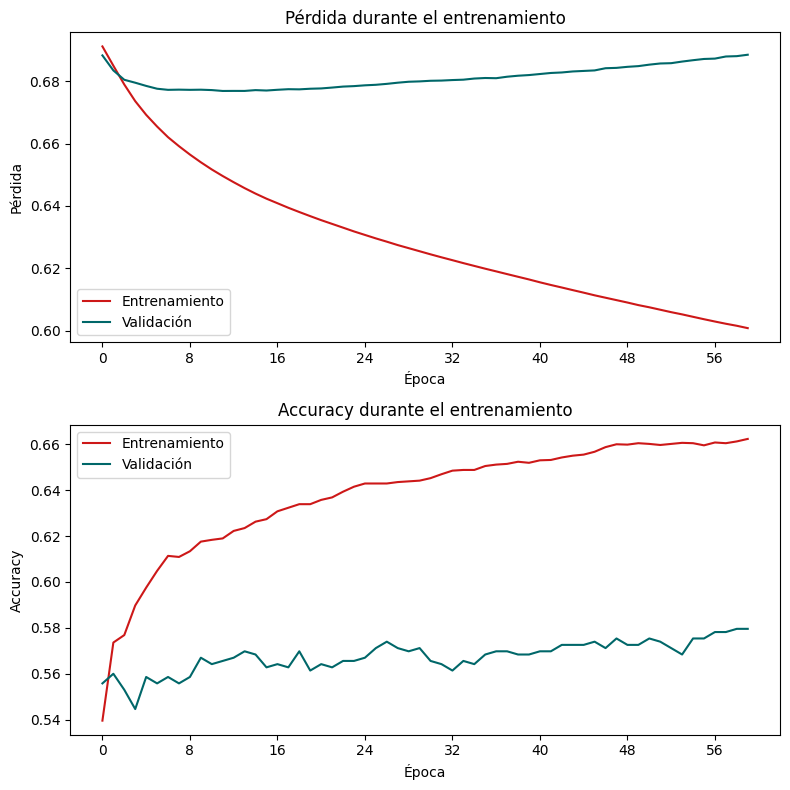


El accuracy en test es: 0.59


In [16]:
from keras.optimizers import Adam

set_random_seeds(100)

X_train, X_test, y_train, y_test = load_MathLearningDataset(test_size=0.25)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=348, stratify=y_train)

learning_rate = 0.0001
epochs = 60
batch_size = 32
optimizer = Adam(learning_rate=learning_rate)

model = create_MathLearning_model(input_dims=X_train.shape[1], reg=False)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])  # Compilar el modelo

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=0)

plot_history(history)

# Medir accuracy
accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
print(f"\nEl accuracy en test es: {accuracy:.2f}")

Y ahora vemos la diferencia con Dropout y BatchNormalization:

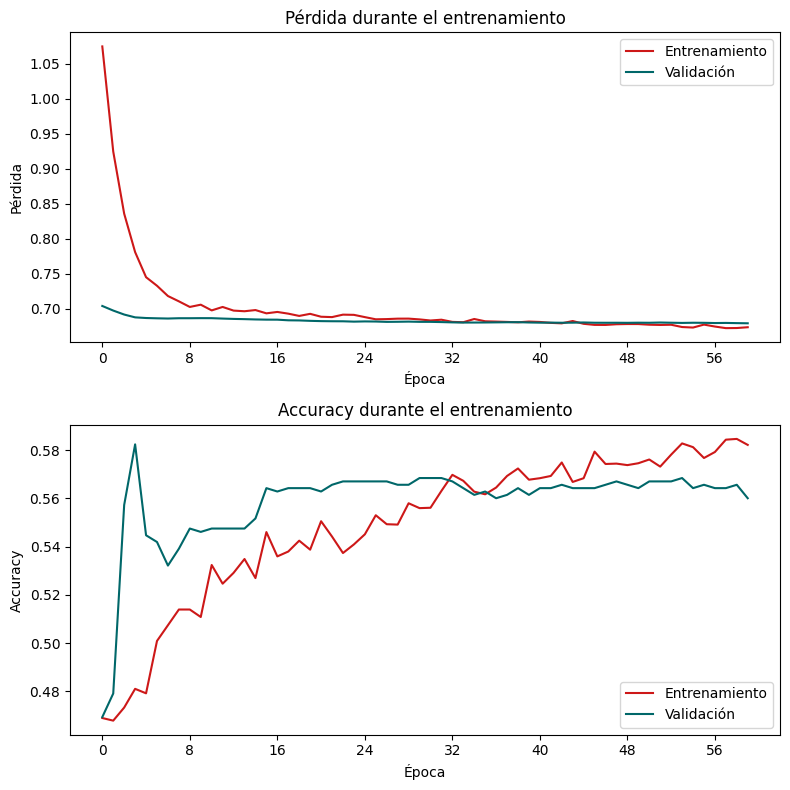


El accuracy en test es: 0.58


In [17]:
set_random_seeds(100)

model = create_MathLearning_model(input_dims=X_train.shape[1], reg=True)

optimizer = Adam(learning_rate=learning_rate)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])  # Compilar el modelo

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=0)

plot_history(history)

# Medir accuracy
accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
print(f"\nEl accuracy en test es: {accuracy:.2f}")

### 2.2 Early stopping
No obstante, se veía claramente como llegaba un punto en el que el modelo no mejoraba en el conjunto de validación. Seguir entrenando no tiene sentido porque podemos empeorar el rendimiento en el conjunto de test; y sino es así, estamos perdiendo tiempo. Para evitar esto, podemos utilizar el early stopping:

Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 4.


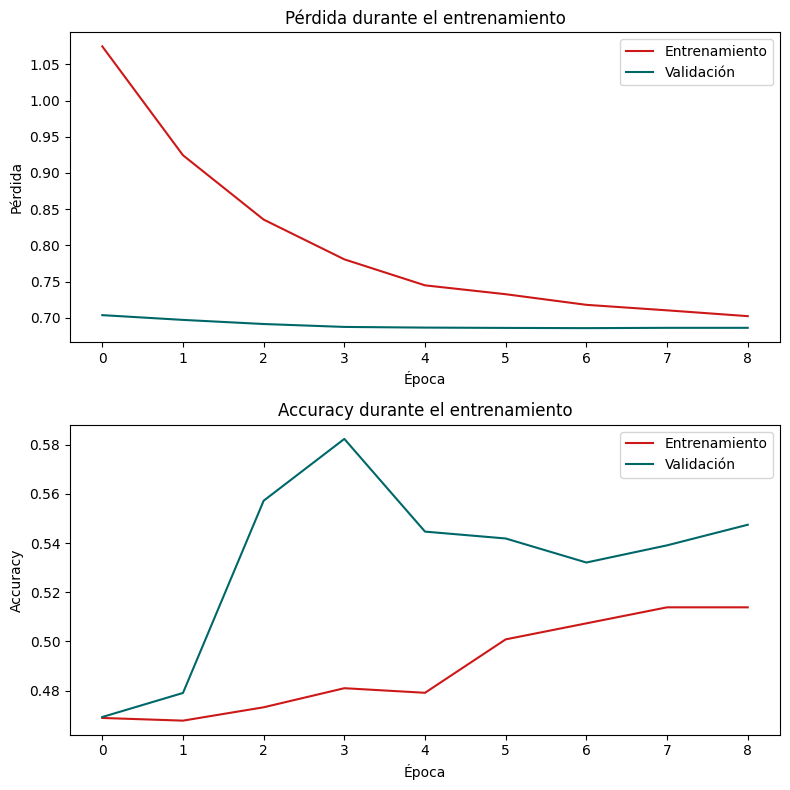


El accuracy en test es: 0.52


In [19]:
from keras.callbacks import EarlyStopping

set_random_seeds(100)

model = create_MathLearning_model(input_dims=X_train.shape[1], reg=True)

optimizer = Adam(learning_rate=learning_rate)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])  # Compilar el modelo

# Si la Accuracy en Validación no mejora durante 5 épocas, detenemos el entrenamiento y volvemos al mejor modelo
early_stopping = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True, verbose=1)

# Ahora podemos poner un número de épocas muy grande porque nos aseguramos de estar siempre mejorando y parar cuando no consigamos mejor rendimiento
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=0,
)

plot_history(history)

# Medir accuracy
accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
print(f"\nEl accuracy en test es: {accuracy:.2f}")

## 3 Problemas multiclase
Hasta ahora hemos visto problemas de clasificación binaria. En problemas multiclase, la función de activación de la última capa debe ser softmax y la función de pérdida categorical_crossentropy. Vamos a ver un ejemplo utilizando el dataset MNIST. Este dataset contiene imágenes de dígitos del 0 al 9 escritos a mano y nuestro objetivo es clasificar a qué dígito corresponde cada imagen.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


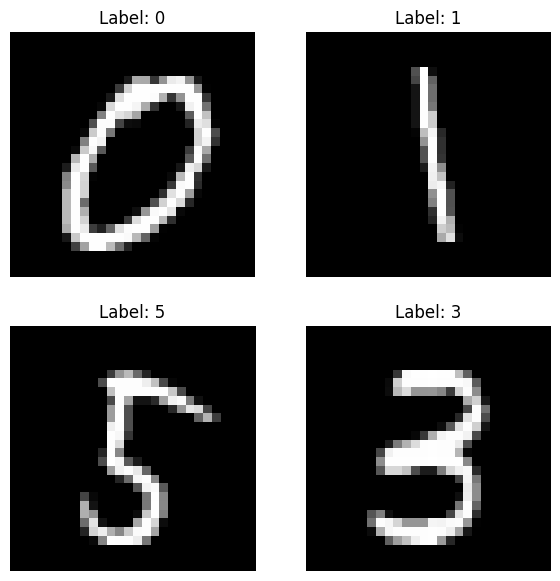

In [20]:
from keras.datasets import mnist
from keras.utils import to_categorical
import matplotlib.pyplot as plt

(X_train, y_train), (X_test, y_test_orig) = mnist.load_data()

X_train = X_train / 255
X_test = X_test / 255

# Separar un conjunto de validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=348, stratify=y_train)

plt.figure(figsize=(7, 7))

for i in range(2):
    for j in range(2):
        plt.subplot(2, 2, i * 2 + j + 1)
        plt.imshow(X_train[i * 2 + j + 1], cmap="gray")
        plt.title(f"Label: {y_train[i * 2 + j + 1]}")
        plt.axis("off")

plt.show()

En este problema tenemos más de una clase. En general, los modelos están preparados para trabajar con etiquetas en formato One Hot Encoding, por lo que debemos convertir las etiquetas a este formato:

In [21]:
y_train = to_categorical(y_train, num_classes=10)  # Esto es como el One Hot Encoding
y_val = to_categorical(y_val, num_classes=10)  # Esto es como el One Hot Encoding
y_test = to_categorical(y_test_orig, num_classes=10)  # Esto es como el One Hot Encoding

### 3.1 Ejercicio
**EJERCICIO: red neuronal para MNIST (20 minutos)**

Crear un modelo de red neuronal utilizando Dropout y BatchNormalization y entrenarlo con los datasets de entrenamiento y validación de MNIST, utilizando early stopping. Utilizar el dataset de test para evaluar el modelo y mostrar la matriz de confusión.

Capas necesarias: Flatten y Dense de salida
+ Hay que utilizar una capa Flatten(input_shape=(28, 28)) como primera capa del modelo para aplanar las imágenes. Esto es necesario porque las imágenes son de 28x28 píxeles y las capas Dense solo aceptan vectores de una dimensión como entrada.
+ Ahora queremos hacer predicciones con 10 clases, por lo que la capa de salida debe tener 10 neuronas (una por clase) y la función de activación softmax (para que cada neurona de salida tenga la probabilidad de pertenecer a la correspondiente clase): Dense(10, activation="softmax").
Ver el código de plot_confusion_matrix()

In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns


def plot_confusion_matrix(y_test_orig, y_pred, target_names=None):
    if target_names is None:
        target_names = "auto"

    cm = confusion_matrix(y_test_orig, y_pred)
    cm_norm = cm / cm.sum(axis=0)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, fmt="d", annot=True, cmap="Reds", xticklabels=target_names, yticklabels=target_names)
    plt.xlabel("Etiquetas predichas")
    plt.ylabel("Etiquetas real")
    plt.title("Matriz de confusión")

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, fmt=".2f", annot=True, cmap="Reds", xticklabels=target_names, yticklabels=target_names)
    plt.xlabel("Etiquetas predichas")
    plt.ylabel("Etiquetas real")
    plt.title("Matriz de confusión normalizada por cada clase")

    plt.show()

**Solucion**

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Accuracy: 0.9805999994277954
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


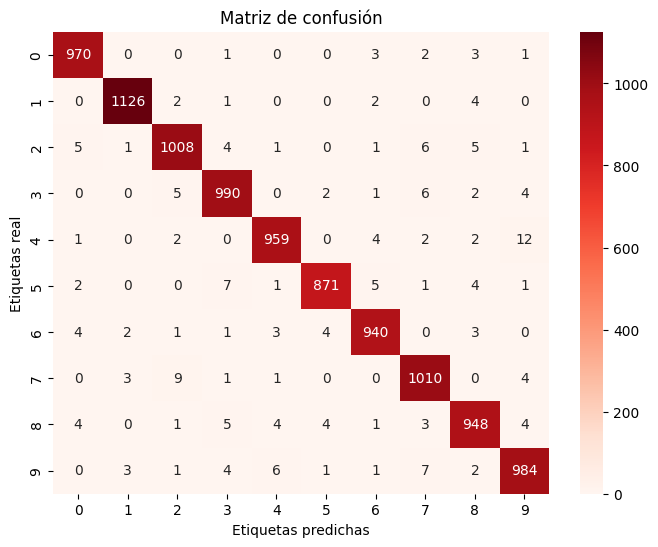

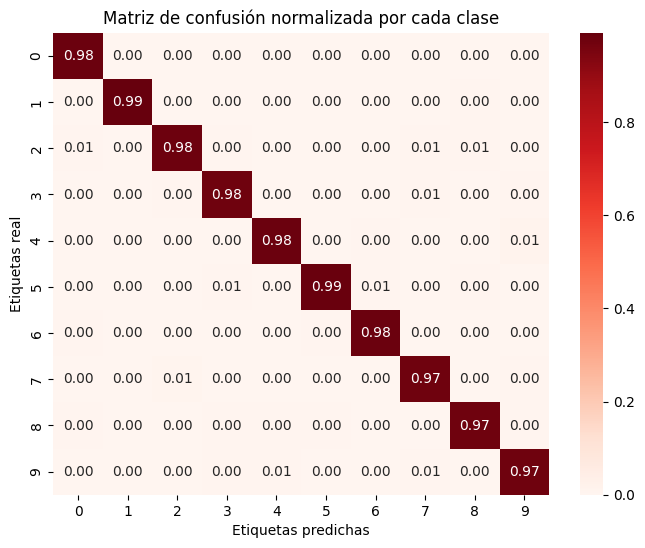

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


# Definir el modelo
model = keras.Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(10, activation='softmax')
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Definir early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy:', accuracy)

# Predecir las etiquetas para el conjunto de prueba
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

# Mostrar la matriz de confusión
plot_confusion_matrix(y_test_orig, y_pred_classes, target_names=range(10))

**Pasos:**

+ 1.Importar las librerías necesarias: tensorflow, keras, Flatten, Dense, Dropout, BatchNormalization, EarlyStopping, confusion_matrix, accuracy_score, matplotlib.pyplot, seaborn.
+ 2.Definir el modelo: Se crea un modelo secuencial con las capas Flatten, Dense, BatchNormalization y Dropout, como se especifica en el enunciado.
+ 3.Compilar el modelo: Se utiliza el optimizador adam, la función de pérdida categorical_crossentropy y la métrica accuracy.
+ 4.Definir early stopping: Se configura EarlyStopping para detener el entrenamiento si la pérdida en el conjunto de validación no mejora durante 5 épocas.
+ 5.Entrenar el modelo: Se entrena el modelo con los datos de entrenamiento y validación, utilizando early stopping.
+ 6.Evaluar el modelo: Se evalúa el modelo con los datos de prueba y se imprime la precisión.
+ 7.Predecir las etiquetas: Se predicen las etiquetas para el conjunto de prueba.
+ 8.Mostrar la matriz de confusión: Se utiliza la función plot_confusion_matrix para mostrar la matriz de confusión.
Recuerda que debes tener el código de plot_confusion_matrix definido en tu notebook.

## 4 Redes convolucionales
Las redes convolucionales son un tipo de red neuronal que se utiliza principalmente para problemas de visión artificial: problemas donde los datos de entrada son imágenes. Las redes convolucionales se basan en las capas convolucionales:
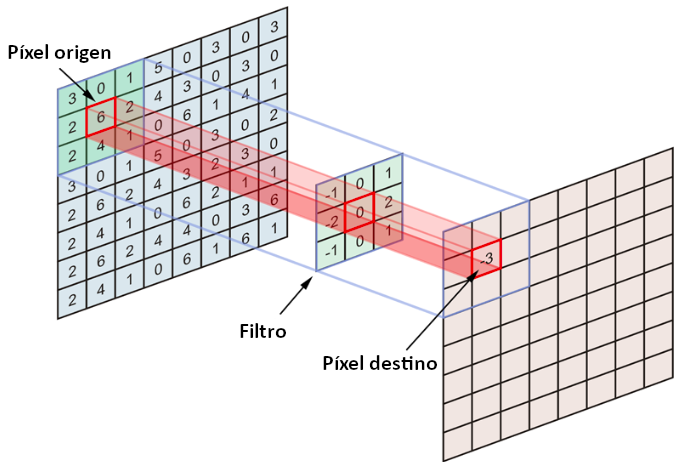
Figure 1: Operación convolucional de una capa convolucional. Imagen extraída de Medium.
También es muy frecuente utilizar capas de pooling para reducir la dimensionalidad de las imágenes:
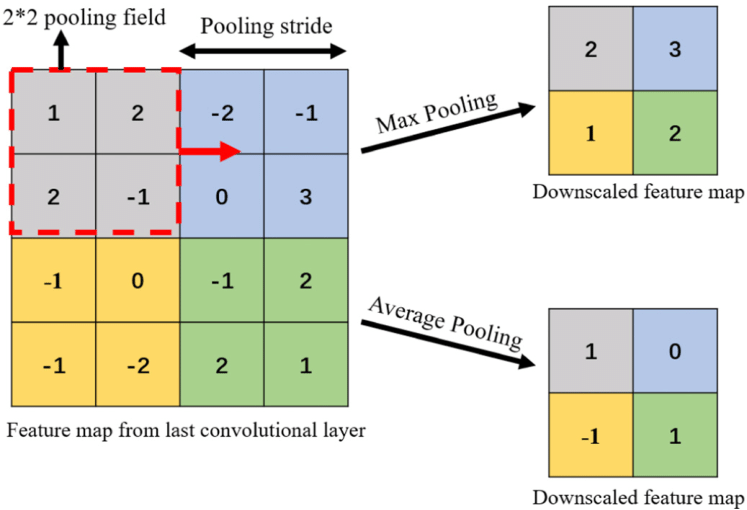
Figure 2: Capa de pooling. Imagen extraída de ResearchGate.
Podemos crear una red convolucional de la misma forma que antes, solo que utilizando capas convolucionales en vez de densas.

In [24]:
from keras.layers import Conv2D, MaxPooling2D

model = Sequential(
    [
        Conv2D(filters=8, kernel_size=(7, 7), input_shape=(28, 28, 1), activation="relu"),
        Dropout(0.25),
        Conv2D(filters=8, kernel_size=(5, 5), activation="relu"),
        Dropout(0.25),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=8, kernel_size=(3, 3), activation="relu"),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation="relu"),
        Dense(10, activation="softmax"),
    ]
)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 22, 22, 8)           │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 22, 22, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 18, 18, 8)           │           1,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 18, 18, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 9, 9, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 8)             │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 7, 7, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 392)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 128)                 │          50,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,186 (211.66 KB)

 Trainable params: 54,186 (211.66 KB)

 Non-trainable params: 0 (0.00 B)

Se entrena de la misma forma:

Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 19.


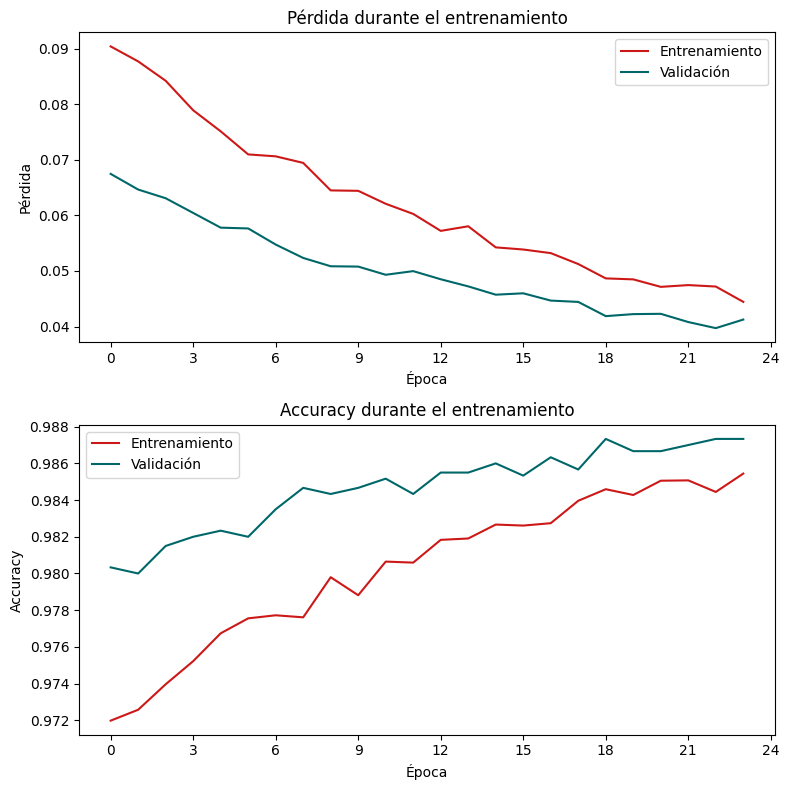

In [27]:
learning_rate = 0.0001
batch_size = 64

# Definir early stopping
early_stopping = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True, verbose=1)

# Compilar el modelo
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=learning_rate), metrics=["accuracy"])

# Entrenar el modelo
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=0,
)

plot_history(history)

Y se evalúa igual:


El accuracy en test es: 0.989


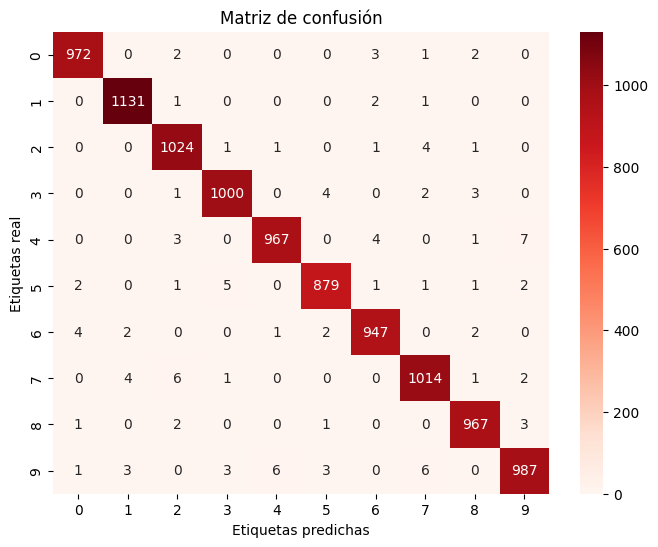

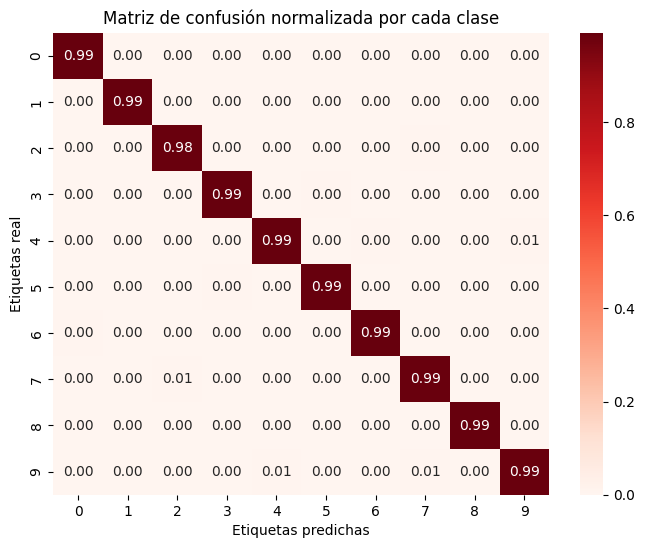

In [29]:
import numpy as np # Import numpy and assign it the alias 'np'

y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)

accuracy = accuracy_score(y_test_orig, y_pred)
print(f"\nEl accuracy en test es: {accuracy:.3f}")

# Visualizamos la matriz de confusión
plot_confusion_matrix(y_test_orig, y_pred)

# 5 Ejercicio
**EJERCICIO FINAL: red convolucional para el dataset de perros y gatos**

Para este ejercicio se van a utilizar los datos de la competición Dogs vs. Cats de kaggle. El objetivo de la competición es entrenar un modelo capaz de clasificar correctamente imágenes de gatos y perros. En el Campus Virtual hay una versión reducida del dataset (menos imágenes de entrenamiento) que podéis utilizar para este ejercicio; también está la versión completa en el CV. La diferencia entre ambos datasets (parcial y completo) es el número de imágenes de entrenamiento, los conjuntos de validación y test son los mismos.

Ver el código para cargar el dataset parcial

In [31]:
import os
import shutil
from tensorflow.keras.preprocessing import image_dataset_from_directory


# Función para cargar el dataset DogsVsCats (parcial o completo)
def load_dataset(image_size, batch_size, dataset_path):
    # Cargar los tres conjuntos
    train_dataset = image_dataset_from_directory(f"{dataset_path}/train", image_size=image_size, batch_size=batch_size)
    validation_dataset = image_dataset_from_directory(
        f"{dataset_path}/validation", image_size=image_size, batch_size=batch_size
    )
    test_dataset = image_dataset_from_directory(f"{dataset_path}/test", image_size=image_size, batch_size=batch_size)

    return train_dataset, validation_dataset, test_dataset


set_random_seeds(100)


dataset_path = "/content/DogsVsCatsPartial"  # Cambiar por vuestro path
image_size = (180, 180)
batch_size = 128
dict_clases = {0: "Gato", 1: "Perro"}

train_dataset, validation_dataset, test_dataset = load_dataset(image_size, batch_size, dataset_path)

Found 5000 files belonging to 2 classes.
Found 2500 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


Unas imágenes de ejemplo:

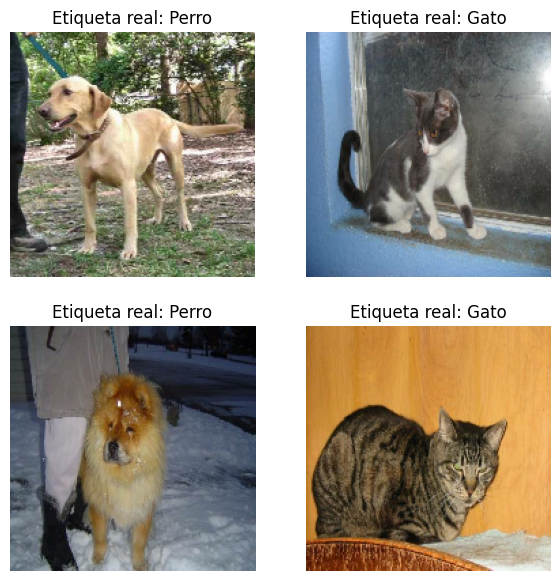

In [36]:
plt.figure(figsize=(7, 7))

for images, labels in train_dataset.take(1):
    for i in range(1, 5):
        plt.subplot(2, 2, i)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Etiqueta real: {dict_clases[labels[i].numpy()]}")
        plt.axis("off")

plt.show()

**Solución**

In [34]:
!pip install tensorflow

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_dogs_vs_cats_partial(image_size=(128, 128), batch_size=32):
    """
    Carga el dataset parcial de Perros vs. Gatos.

    Args:
        image_size (tuple, optional): El tamaño deseado para redimensionar las imágenes. Por defecto es (128, 128).
        batch_size (int, optional): El tamaño del lote para la carga de datos. Por defecto es 32.

    Returns:
        tuple: Una tupla que contiene los generadores de datos de entrenamiento y validación.
    """

    train_datagen = ImageDataGenerator(rescale=1./255,  # Reescalar los valores de píxeles a [0, 1]
                                       shear_range=0.2,  # Aplicar transformaciones de cizallamiento
                                       zoom_range=0.2,   # Aplicar zoom aleatorio
                                       horizontal_flip=True)  # Voltear imágenes horizontalmente

    test_datagen = ImageDataGenerator(rescale=1./255)  # Solo reescalar para los datos de validación/prueba

    train_generator = train_datagen.flow_from_directory(
        'DogsVsCatsPartial/train',  # Directorio de datos de entrenamiento
        target_size=image_size,   # Redimensionar las imágenes
        batch_size=batch_size,     # Tamaño del lote
        class_mode='binary')      # Modo de clasificación binaria (perros vs. gatos)

    validation_generator = test_datagen.flow_from_directory(
        'DogsVsCatsPartial/validation',  # Directorio de datos de validación
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary')

    return train_generator, validation_generator

**Explicación:**

+ 1 . **Importar bibliotecas necesarias**: Se importan tensorflow, keras para construir y entrenar la CNN, e ImageDataGenerator para la aumentación de datos y la carga.
+ 2 . **Función load_dogs_vs_cats_partial**:
++ Esta función se encarga de cargar y preprocesar el dataset parcial de Perros vs. Gatos.
-+ ImageDataGenerator: Se crean dos instancias de ImageDataGenerator, una para los datos de entrenamiento con aumentaciones (como cizallamiento, zoom y volteo horizontal) y otra para los datos de validación/prueba con solo reescalado.
+++ Las aumentaciones durante el entrenamiento ayudan al modelo a generalizar mejor y evitar el sobreajuste.
++ flow_from_directory: Este método se usa para cargar imágenes desde directorios. Infiere automáticamente las etiquetas a partir de la estructura de directorios (por ejemplo, 'DogsVsCatsPartial/train/cats' y 'DogsVsCatsPartial/train/dogs').
++ **Parámetros**:
target_size: Especifica el tamaño al que se redimensionarán las imágenes.
batch_size: Establece el tamaño del lote para el entrenamiento y la validación.
class_mode: 'binary' indica un problema de clasificación binaria (perros vs. gatos).
++ **Retorno**: La función devuelve dos generadores de datos, uno para entrenamiento y otro para validación.
Construyendo el modelo CNN:

Tendrás que definir una arquitectura CNN usando capas de Keras como Conv2D, MaxPooling2D, Flatten y Dense. Aquí tienes un ejemplo básico:

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),  # Capa convolucional 1
    MaxPooling2D((2, 2)),  # Capa de Max Pooling 1
    Conv2D(64, (3, 3), activation='relu'),  # Capa convolucional 2
    MaxPooling2D((2, 2)),  # Capa de Max Pooling 2
    Conv2D(128, (3, 3), activation='relu'),  # Capa convolucional 3
    MaxPooling2D((2, 2)),  # Capa de Max Pooling 3
    Flatten(),  # Aplanar la salida para las capas densas
    Dense(128, activation='relu'),  # Capa densa 1
    Dense(1, activation='sigmoid')  # Capa de salida (clasificación binaria: activación sigmoid)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
